In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler
pd.options.mode.chained_assignment = None 
import gender_guesser.detector as gender
d=gender.Detector(case_sensitive=False)

In [2]:
raw_train=pd.read_csv('train.csv')
raw_test=pd.read_csv('test.csv')
train=raw_train[:]
test=raw_test[:]

In [4]:
def cabin_separation(df):
    
    df['CabinDeck'] = df['Cabin'].str.split('/', expand=True)[0]
    df['CabinNum']  = df['Cabin'].str.split('/', expand=True)[1]
    df['CabinSide'] = df['Cabin'].str.split('/', expand=True)[2]
    
    df.drop(columns = ['Cabin'], inplace = True)
    return df

train=cabin_separation(train)
test=cabin_separation(test)

In [5]:
cols=list(train.columns)
cols.remove('Transported')

In [6]:
def logic(df, age_limit = 18):
    df['RoomService'] = np.where(df['Age'] < age_limit, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['Age'] < age_limit, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['Age'] < age_limit, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['Age'] < age_limit, 0, df['Spa'])
    df['VRDeck'] = np.where(df['Age'] < age_limit, 0, df['VRDeck'])

    df['RoomService'] = np.where(df['CryoSleep'] == True, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['CryoSleep'] == True, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['CryoSleep'] == True, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['CryoSleep'] == True, 0, df['Spa'])
    df['VRDeck'] = np.where(df['CryoSleep'] == True, 0, df['VRDeck'])
    
    return df

train=logic(train)
test=logic(test)

In [7]:
imputer_a = SimpleImputer(strategy='most_frequent')
imputer_b = SimpleImputer(strategy='median')
scaler = StandardScaler()

for i in cols:
    if(train[i].dtype!=np.int64 and train[i].dtype!=np.float64 and train[i].dtype!=np.bool_):
        train[i]=imputer_a.fit_transform(train[[i]]).ravel()
        test[i]=imputer_a.transform(test[[i]]).ravel()
    elif(train[i].dtype!=np.bool_):
        train[i]=imputer_b.fit_transform(train[[i]]).ravel()
        train[i]=scaler.fit_transform(train[[i]]).ravel()
        test[i]=imputer_b.transform(test[[i]]).ravel()
        test[i]=scaler.transform(test[[i]]).ravel()
    if(train[i].dtype==np.bool_):
        train[i]=train[i]*1
        test[i]=test[i]*1
        

train.CryoSleep=train['CryoSleep'].astype(int)
train.VIP=train['VIP'].astype(int)
train.Transported=train.Transported*1
test.CryoSleep=test['CryoSleep'].astype(int)
test.VIP=test['VIP'].astype(int)

In [8]:
def total_billed(df):
    df['TotalBilled'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df

train=total_billed(train)
test=total_billed(test)

In [9]:
train['FirstName']=[x.partition(' ')[0] for x in train.Name]
train['Gender']=[d.get_gender(x) for x in train.FirstName]
train.drop(columns = ['FirstName'], inplace = True)
test['FirstName']=[x.partition(' ')[0] for x in test.Name]
test['Gender']=[d.get_gender(x) for x in test.FirstName]
test.drop(columns = ['FirstName'], inplace = True)

In [10]:
cab=train.loc[:,['CabinNum','Transported']]
cab=cab.groupby('CabinNum', as_index=False).agg(lambda x: sum(x)/len(x))
cab=cab.loc[(cab['Transported']<0.05) | (cab['Transported']>0.95)]

In [11]:
X=train.drop(['Transported','PassengerId','Name','CabinNum'],axis=1)
X=pd.get_dummies(X,columns=['HomePlanet','Destination','CabinDeck','CabinSide','Gender'])
Y=train.Transported
X_t=test.drop(['PassengerId','Name','CabinNum'],axis=1)
X_t=pd.get_dummies(X_t,columns=['HomePlanet','Destination','CabinDeck','CabinSide','Gender'])

In [12]:
len(tf.config.list_physical_devices('GPU'))

1

In [91]:
model = keras.Sequential([
        layers.Dense(600, activation='relu', input_shape=(X.shape[-1],), bias_regularizer=keras.regularizers.L2(0.002)),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.15),
        layers.BatchNormalization(),
        layers.Dense(50, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(25, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    
metrics = [
    'accuracy',
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0002), loss="binary_crossentropy",metrics=metrics)

In [92]:
history=model.fit(X,Y,epochs=25,validation_split = 0.1,batch_size=100,shuffle=True)

Epoch 1/25


2022-06-06 07:40:04.439214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.6708 - precision: 0.6793 - recall: 0.6662

2022-06-06 07:40:08.962468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 6s 40ms/step - loss: 0.6140 - accuracy: 0.6708 - precision: 0.6793 - recall: 0.6662 - val_loss: 0.6309 - val_accuracy: 0.7126 - val_precision: 0.8645 - val_recall: 0.4557
Epoch 2/25
79/79 [==============================] - 2s 28ms/step - loss: 0.5044 - accuracy: 0.7541 - precision: 0.7747 - recall: 0.7271 - val_loss: 0.5631 - val_accuracy: 0.7552 - val_precision: 0.8876 - val_recall: 0.5443
Epoch 3/25
79/79 [==============================] - 2s 29ms/step - loss: 0.4803 - accuracy: 0.7613 - precision: 0.7763 - recall: 0.7445 - val_loss: 0.5189 - val_accuracy: 0.7632 - val_precision: 0.8759 - val_recall: 0.5739
Epoch 4/25
79/79 [==============================] - 2s 27ms/step - loss: 0.4536 - accuracy: 0.7759 - precision: 0.7857 - recall: 0.7681 - val_loss: 0.4772 - val_accuracy: 0.7713 - val_precision: 0.8485 - val_recall: 0.6207
Epoch 5/25
79/79 [==============================] - 2s 27ms/step - loss: 0.4516 - accuracy: 0.7792 - precision: 0.7891 

In [93]:
model.evaluate(X,Y)

272/272 [==============================] - 2s 8ms/step - loss: 0.3764 - accuracy: 0.8197 - precision: 0.8207 - recall: 0.8216


[0.3763964772224426,
 0.8197400569915771,
 0.8206707835197449,
 0.8216080665588379]

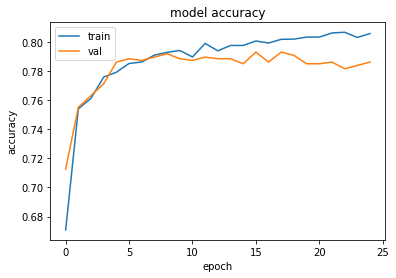

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

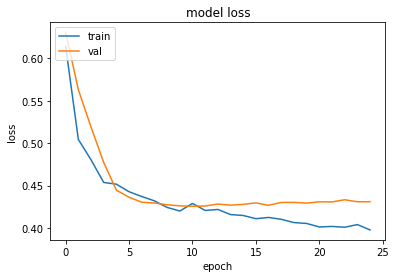

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [142]:
Y_t = pd.DataFrame(raw_test.PassengerId)
Y_t['Transported'] = model.predict(X_t) > 0.5

In [ ]:
Y_t_exp=Y_t[:]
Y_t_exp['Transported']=[x for x in ]

In [121]:
sum(Y_t_exp.Transported==Y_t.Transported)/len(Y_t)

1.0

In [107]:
Y_t.to_csv('pred11.csv',index=False)